# Performance assessment

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from interpret.glassbox import ExplainableBoostingClassifier
import geopandas as gpd
import pickle
from tqdm.notebook import tqdm
import seaborn as sns

## Data pre-processing

In [2]:
data=gpd.read_file('Data/SUs.shp')
data['x']=data.geometry.centroid.x
data['y']=data.geometry.centroid.y

In [3]:
litho = ['Lit3', 'Lit5', 'Lit6', 'Lit10', 'Lit12', 'Lit16', 'Lit17']
data['litho'] = data[litho].idxmax(axis=1)
data['litho']=data.litho.astype('category')
lcover=['LC1','LC2', 'LC3', 'LC4', 'LC5', 'LC7']
data['lcover']=data[lcover].idxmax(axis=1)
data['lcover']=data.lcover.astype('category')
data['Catchment']=data.Catchment.astype('category')
soil=['Soil1', 'Soil2','Soil3', 'Soil4', 'Soil5', 'Soil6', 'Soil7', 'Soil8']
data['soil'] = data[soil].idxmax(axis=1)
data['soil']=data.soil.astype('category')

In [4]:
filename = 'Variable_Selection/variable_selection.pkl'
results_auc= pickle.load(open(filename, 'rb'))

In [5]:
best_sub=results_auc[5]
cov=best_sub['Selected Features']
cov

['Delta_mean',
 'rain30day',
 'Catchment',
 'AreaSU',
 'Slope_std',
 'soil',
 'lcover',
 'litho',
 'CS_mean',
 'CA_mean']

In [6]:
X=data[cov]
data['Landslide'] = data['Landslide'].replace(np.nan, 0)
y=data.Landslide

In [7]:
unique,counts=np.unique(y, return_counts=True)
n_classes=2
w_0=len(y)/(n_classes*counts[0])
w_1=len(y)/(n_classes*counts[1])

## Random Cross Validation

In [13]:
from sklearn.model_selection import RepeatedKFold
def rcv():
    cv = RepeatedKFold(n_splits=10,n_repeats=10,random_state=42)
    i=0
    ebm=ExplainableBoostingClassifier(n_jobs=-1,outer_bags=30, min_samples_leaf=2,
                                     validation_size=0.2,interactions=[(0,1)], exclude=[1])
    
    for fold, (train, test) in tqdm(enumerate(cv.split(X, y)), total=100):
        X_train=X.loc[train]
        y_train=y.loc[train]
        X_test=X.loc[test]
        y_test=y.loc[test]
        sample_weights = np.empty(len(y_train))
        sample_weights[y_train == 0] = w_0
        sample_weights[y_train == 1] = w_1
        ebm.fit(X_train, y_train,sample_weight=sample_weights,)
        ebm.term_scores_[1] = np.zeros_like(ebm.term_scores_[1])
        ebm.term_scores_[2] = np.zeros_like(ebm.term_scores_[2])
        preds=ebm.predict_proba(X_test)[:, 1]
        np.save(f'Performance/rcv/rcv_pred{str(i)}.npy',preds)
        np.save(f'Performance/rcv/rcv_true{str(i)}.npy',y[test])
        i+=1
    return y,preds


In [14]:
y,preds=rcv()

  0%|          | 0/100 [00:00<?, ?it/s]

### RCV plot

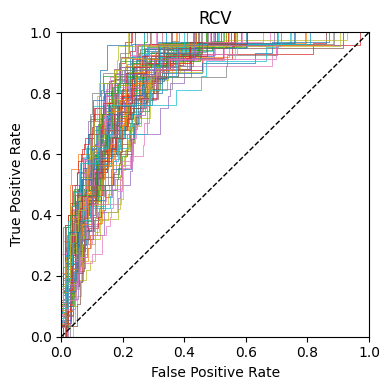

In [16]:
import sklearn.metrics
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
import numpy as np 
figure(figsize=(4, 4), dpi=100)
Aucs=[]
for i in range(0,100):
    preds=np.load(f'Performance/rcv/rcv_pred{str(i)}.npy')
    truths=np.load(f'Performance/rcv/rcv_true{str(i)}.npy') 
    fpr,tpr,thresholds=sklearn.metrics.roc_curve(truths.flatten(), preds.flatten())
    plt.plot(
        fpr,
        tpr,
        lw=0.5,
    )
    Aucs.append(sklearn.metrics.auc(fpr,tpr))

ax=plt.plot([0, 1], [0, 1], color="black", lw=1, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("RCV")
plt.tight_layout()
plt.savefig('Outputs/plots/rocs_rcv.png',dpi=300)
plt.show()

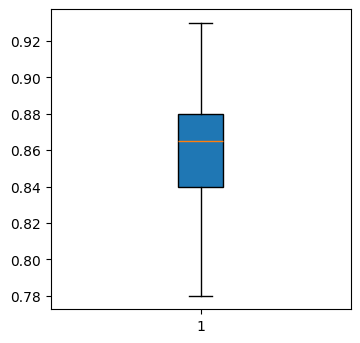

In [17]:
import seaborn as sns
auc_rcv=np.round(Aucs,2)
fig = plt.figure(figsize =(3,3))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(auc_rcv,patch_artist = True,showfliers = True)
plt.savefig('Outputs/plots/box_rcv.png',dpi=300)
plt.show()

## Spatial Cross Validation

### create a 5 x 10 partition

In [18]:
coordinates=data[["x","y"]].values

result_df = pd.DataFrame()

for i in range(10):
    kmeans = KMeans(init="random", n_clusters=5, n_init=1, max_iter=300, random_state=None)
    kmeans.fit(coordinates)
    # Create a new column for cluster assignments
    result_df[f'iteration_{i}'] = kmeans.labels_
data = pd.concat([data, result_df], axis=1)

### SCV routines

In [20]:
def scv():
    columns=['iteration_0', 'iteration_1','iteration_2', 'iteration_3', 'iteration_4', 'iteration_5', 'iteration_6',
             'iteration_7', 'iteration_8', 'iteration_9']
    for column in columns:
        for i in tqdm (range(0,5)):
            print(column + str(i))
            ebm=ExplainableBoostingClassifier(n_jobs=-1,outer_bags=30, min_samples_leaf=2,
                                     validation_size=0.2,interactions=[(0,1)], exclude=[1])
            train_index=data.index[data[column]!=i].tolist()
            test_index=data.index[data[column]==i].tolist()
            print(f"Number of train set{len(train_index)}")
            X_train=X.loc[train_index]
            y_train=y.loc[train_index]
            X_test=X.loc[test_index]
            y_test=y.loc[test_index]
            sample_weights = np.empty(len(y_train))
            sample_weights[y_train == 0] = w_0
            sample_weights[y_train == 1] = w_1
            ebm.fit(X_train, y_train,sample_weight=sample_weights,)
            ebm.term_scores_[1] = np.zeros_like(ebm.term_scores_[1])
            ebm.term_scores_[2] = np.zeros_like(ebm.term_scores_[2])
            preds=ebm.predict_proba(X_test)[:, 1]
            np.save(f'Performance/scv/scv_pred_{column}_{str(i)}3.npy', preds)
            np.save(f'Performance/scv/scv_true_{column}_{str(i)}3.npy', y_test)
            del ebm
            i+=1

In [21]:
scv()

  0%|          | 0/5 [00:00<?, ?it/s]

iteration_00
Number of train set1682
iteration_01
Number of train set1695
iteration_02
Number of train set1523
iteration_03
Number of train set1621
iteration_04
Number of train set1675


  0%|          | 0/5 [00:00<?, ?it/s]

iteration_10
Number of train set1600
iteration_11
Number of train set1575
iteration_12
Number of train set1703
iteration_13
Number of train set1609
iteration_14
Number of train set1709


  0%|          | 0/5 [00:00<?, ?it/s]

iteration_20
Number of train set1671
iteration_21
Number of train set1685
iteration_22
Number of train set1515
iteration_23
Number of train set1622
iteration_24
Number of train set1703


  0%|          | 0/5 [00:00<?, ?it/s]

iteration_30
Number of train set1601
iteration_31
Number of train set1700
iteration_32
Number of train set1615
iteration_33
Number of train set1652
iteration_34
Number of train set1628


  0%|          | 0/5 [00:00<?, ?it/s]

iteration_40
Number of train set1603
iteration_41
Number of train set1594
iteration_42
Number of train set1588
iteration_43
Number of train set1679
iteration_44
Number of train set1732


  0%|          | 0/5 [00:00<?, ?it/s]

iteration_50
Number of train set1601
iteration_51
Number of train set1602
iteration_52
Number of train set1731
iteration_53
Number of train set1682
iteration_54
Number of train set1580


  0%|          | 0/5 [00:00<?, ?it/s]

iteration_60
Number of train set1601
iteration_61
Number of train set1615
iteration_62
Number of train set1628
iteration_63
Number of train set1652
iteration_64
Number of train set1700


  0%|          | 0/5 [00:00<?, ?it/s]

iteration_70
Number of train set1584
iteration_71
Number of train set1651
iteration_72
Number of train set1719
iteration_73
Number of train set1627
iteration_74
Number of train set1615


  0%|          | 0/5 [00:00<?, ?it/s]

iteration_80
Number of train set1710
iteration_81
Number of train set1607
iteration_82
Number of train set1532
iteration_83
Number of train set1649
iteration_84
Number of train set1698


  0%|          | 0/5 [00:00<?, ?it/s]

iteration_90
Number of train set1601
iteration_91
Number of train set1700
iteration_92
Number of train set1652
iteration_93
Number of train set1628
iteration_94
Number of train set1615


### Roc of SCVs 

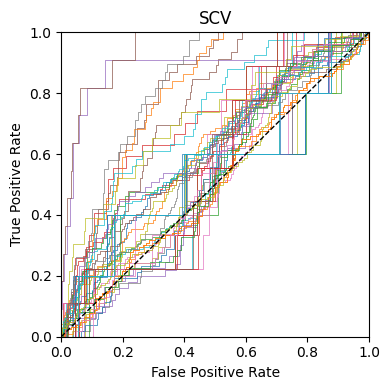

In [25]:
figure(figsize=(4, 4), dpi=100)
Aucs2=[]
columns=['iteration_0', 'iteration_1','iteration_2', 'iteration_3', 'iteration_4', 'iteration_5', 'iteration_6',
             'iteration_7', 'iteration_8', 'iteration_9']
for column in columns:
    for i in range(0,5):
        preds=np.load(f'Performance/scv/scv_pred_{column}_{str(i)}.npy')
        truths=np.load(f'Performance/scv/scv_true_{column}_{str(i)}.npy')
        fpr,tpr,thresholds=sklearn.metrics.roc_curve(truths.flatten(), preds.flatten())
        plt.plot(fpr,tpr,lw=0.5,label=f"ValArea{str(i)}",)
        Aucs2.append(sklearn.metrics.auc(fpr,tpr))

ax=plt.plot([0, 1], [0, 1], color="black", lw=1, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("SCV")
plt.tight_layout()
plt.savefig('Outputs/plots/rocs_scv.png',dpi=300)
plt.show()

### Box plot of SCVs

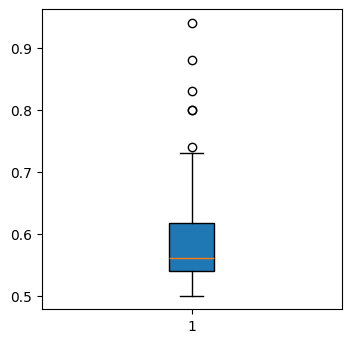

In [26]:
import seaborn as sns
auc_scv=np.round(Aucs2,2)
fig = plt.figure(figsize =(3,3))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(auc_scv,patch_artist = True,showfliers = True)
plt.savefig('Outputs/plots/box_scv.png',dpi=300)
plt.show()